In [20]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from scipy import signal
from scipy.io import wavfile
import sklearn
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime, timedelta

In [21]:
# Загрузка экспериментальных данных и используемые методы
sample_rate, audio_data = wavfile.read('/Users/bogda/Documents/NFS/ Научка/Исходные данные/ExpSummer2024/TASCAM_Files/TASCAM_0049S3.wav')
df = pd.read_excel('/Users/bogda/Desktop/Acoustics/Scientific/Таблицы Данных/Conducting an experiment 30_08.xlsx')

print(f"Частота дискретизации: {sample_rate} Гц")
print(f"Форма массива данных: {audio_data.shape}")
print(audio_data)

def plot1 (X1, Y1, name):
    plt.figure(figsize=(10,4))
    plt.plot(X1, Y1, color='blue')
    plt.ylabel('Амплитуда, у.е.')
    plt.title(name)
    plt.grid(True)
    plt.show()
    
def plot1_f (X1, Y1, name, freq_filt:int):
    plt.figure(figsize=(10,4))
    plt.plot(X1, Y1, color='blue')
    plt.ylabel('Амплитуда, у.е.')
    plt.title(name)
    plt.grid(True)
    plt.xlim(-freq_filt,freq_filt)
    plt.show()   
    
def plot2 (Y1, X1, Y2, X2):
    
    plt.plot(X2, Y2, color='red')
    plt.plot(X1, Y1, color='blue')
    plt.legend()
    plt.grid(True)
    plt.show()

def corr_t(data1, data2):
    mn=min([len(data1), len(data2)])
    data1 = data1[0:mn]
    data2 = data2[0:mn]
    data1_f = ifft(data1)
    data2_f = ifft(data2)
    return np.fft.fftshift(fft(data1_f*np.conj(data2_f)))

def corr_f(data1, data2, f1):
    mn = min(len(data1), len(data2))
    data1_f = ifft(data1)
    data2_f = ifft(data2)
    s1 = np.zeros(mn)
    s2 = np.zeros(mn)
    f = fftfreq(mn, 1 / sample_rate)

    for i in range (0, mn):
        if f[i] > -f1:
            if f[i] < f1:
                s1[i] = data1_f[i]
                s2[i] = data2_f[i]

    fft_abs_s1 = fft((np.abs(s1))**2)
    fft_abs_s2 = fft((np.abs(s2))**2)
    
    corr_f = ifft((fft_abs_s1)*np.conj(fft_abs_s2))
    return corr_f


def count_time(first, df):
    cf_time = '15:26:16'
    cd_time = str(df.loc[first, 'Start time'])
    dur_time = str((df.loc[first, 'Duration']))
    c_time_dt = datetime.strptime(cf_time, "%H:%M:%S")
    x_time_dt = datetime.strptime(cd_time, "%H:%M:%S")
    duration = datetime.strptime(dur_time, "%H:%M:%S")
    # print(type(duration))
    # print(type(x_time_dt))
    delta = (x_time_dt -  c_time_dt).seconds%86400
    time_b_1 = delta
    time_b_2 = delta + duration.second
    return time_b_1, time_b_2


def cr_arr_t(first, second):
    t1_beg, t1_end = count_time(first, df)
    t2_beg, t2_end = count_time(second, df)

    t_int1 = (t > t1_beg) & (t < t1_end)
    t_int2 = (t > t2_beg) & (t < t2_end)

    t1 = t[t_int1]
    t2 = t[t_int2]

    f1 = fftfreq(int(min(len(t1), len(t2))), 1 / sample_rate) # Массив частот
    f2 = fftfreq(int(min(len(t1), len(t2))), 1 / sample_rate) # Массив частот
    array = [t_int1, t_int2, t1, t2, f1, f2]
    return array

def norm_max (data):
    return data/max(data)

def load_mat(data_1_str: str):
    dataset = loadmat(data_1_str)
    dat = [[element for element in upperElement] for upperElement in dataset['dataa']]
    data=[]
    
    for i in range (0,len(dat[0])):
        data.append(dat[0][i])

    if len(dat[0])%2==1:
        data=data[:len(dat[0])-1]

    return data

def first_second_part(data):
    data_first = []
    data_second = []
    for i in range(0,int(len(data)/2)):
        data_first.append(data[i])
    
    for i in range(int(len(data)/2),int(len(data))):
        data_second.append(data[i])

    return data_first, data_second

t = np.arange(int(len(audio_data)))/sample_rate # Массив времен


Частота дискретизации: 44100 Гц
Форма массива данных: (189858816,)
[0 0 0 ... 0 0 0]


In [56]:
# Создание массивов, используемых в обработке
t_f_arr_1 = cr_arr_t(44, 44)
audio_data1_f1 = audio_data[t_f_arr_1[0]]
audio_data1_f1 = norm_max(audio_data1_f1)
audio_data2_f1 = audio_data[t_f_arr_1[1]]
audio_data2_f1 = norm_max(audio_data2_f1)

In [59]:
# Создание массивов, используемых в обработке
t_f_arr_2 = cr_arr_t(44, 45)
audio_data1_f2 = audio_data[t_f_arr_2[0]]
audio_data1_f2 = norm_max(audio_data1_f2)
audio_data2_f2 = audio_data[t_f_arr_2[1]]
audio_data2_f2 = norm_max(audio_data2_f2)


In [ ]:
# Графики исследований
plt.plot(t_f_arr_1[2], audio_data1_f1, color='red', label='Small')
plt.show()

plt.plot(t_f_arr_1[3], audio_data2_f1, color='blue', label='Small')
plt.show()

In [ ]:
# Графики исследований
plt.plot(t_f_arr_2[2], audio_data1_f2, color='red', label='Small')
plt.show()

plt.plot(t_f_arr_2[3], audio_data2_f2, color='blue', label='Small')
plt.show()

In [ ]:
plt.plot(t_f_arr_1[4], corr_f(audio_data1_f1, audio_data2_f1, 750), color='red')
plt.xlim(-1000, 1000)
plt.show()

plt.plot(t_f_arr_2[5], corr_f(audio_data1_f2, audio_data2_f2, 750), color='blue')
plt.xlim(-1000, 1000)
plt.show()

In [ ]:
plot1 (t_f_arr_2[2], corr_t(audio_data1_f2, audio_data2_f2), 'Rare')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


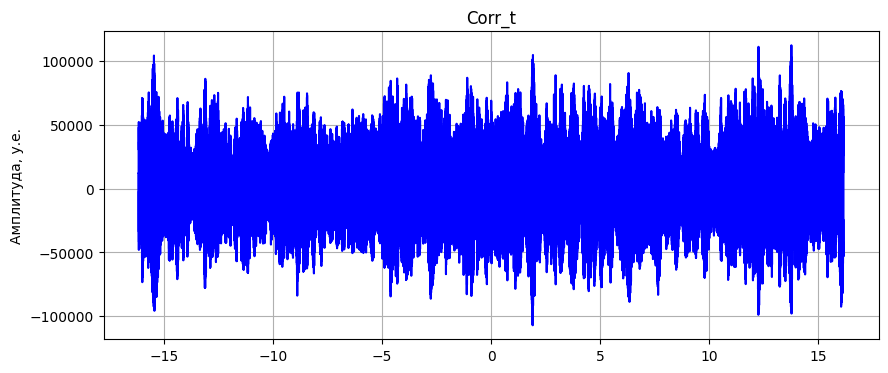

/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_1575/476751496.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  s1[i] = data1_f[i]
/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_1575/476751496.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  s2[i] = data2_f[i]


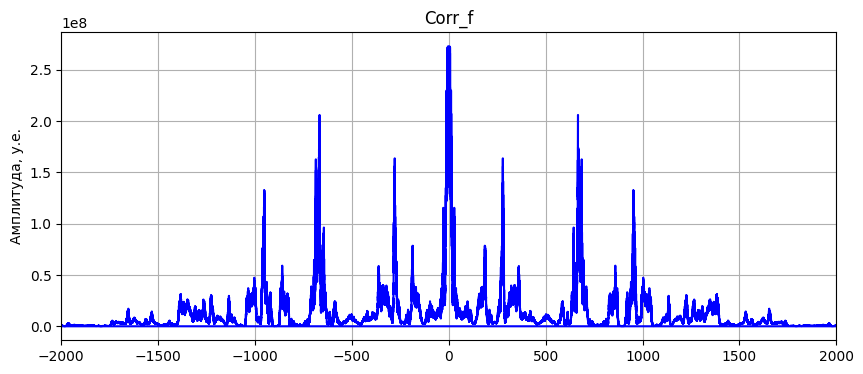

In [28]:
data1_0db = load_mat('/Users/bogda/Documents/NFS/ Научка/Исходные данные/Matlab_Files/2023.03.31-11.44.02_channel_0.mat')
data1_70db = load_mat('/Users/bogda/Documents/NFS/ Научка/Исходные данные/Matlab_Files/2023.03.31-11.42.29_channel_0.mat')
Fs = 48000
data_first, data_second = first_second_part(data1_0db)
mn = min(len(data_first), len(data_second))
t = np.arange(int(mn))/Fs
t_central = t - mn/Fs/2
f1 = fftfreq(mn, 1 / Fs)
f = fftfreq(len(data1_70db), 1 / Fs)
c_t1 = corr_t(data_first, data_second)
c_f1 = corr_f(data_first, data_second, 1000)

In [ ]:
plot1(t_central, c_t1, 'Corr_t')
plot1_f(f1, c_f1, 'Corr_f', 2000)

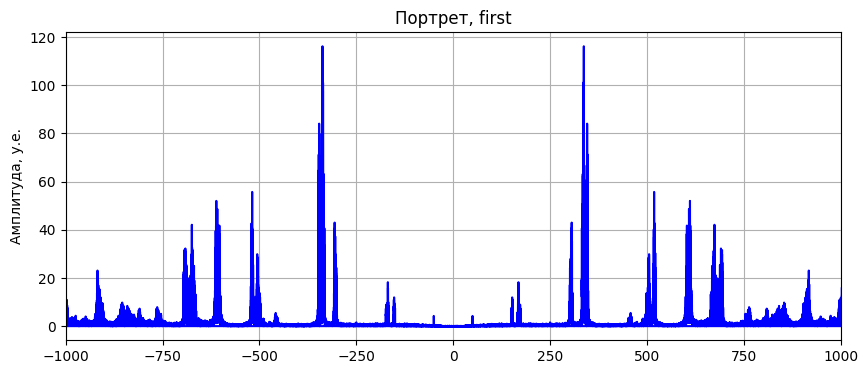

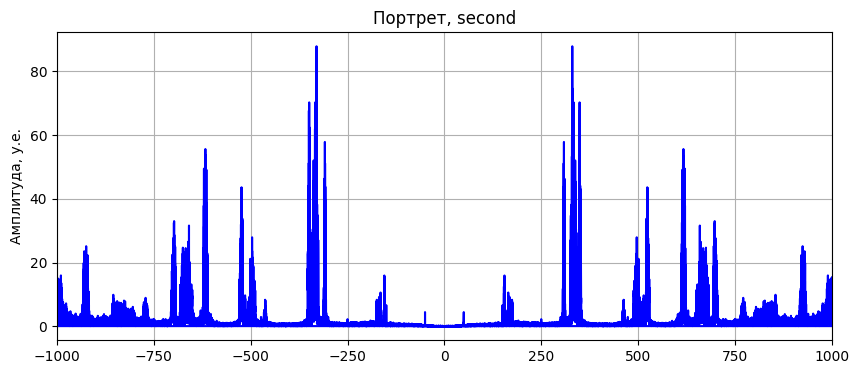

In [24]:
plot1_f(f1, np.abs(ifft(data_first)), "Портрет, first", 1000)
plot1_f(f1, np.abs(ifft(data_second)), "Портрет, second", 1000)

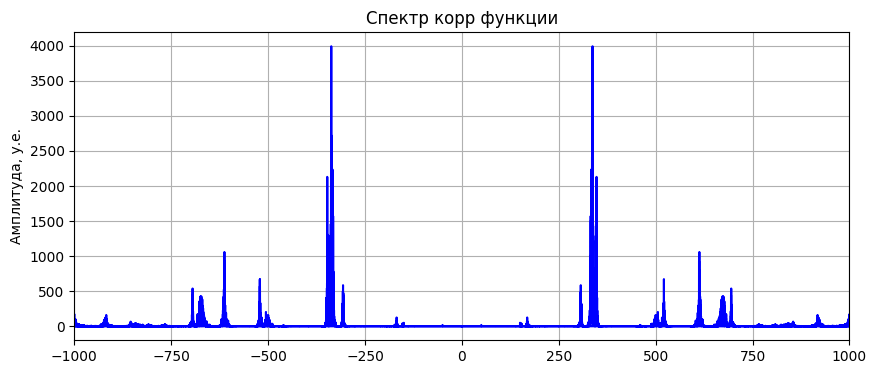

In [31]:
data_fft = ifft(corr_t(data_first, data_second))
plot1_f(f1, np.abs(data_fft), 'Спектр корр функции', 1000)


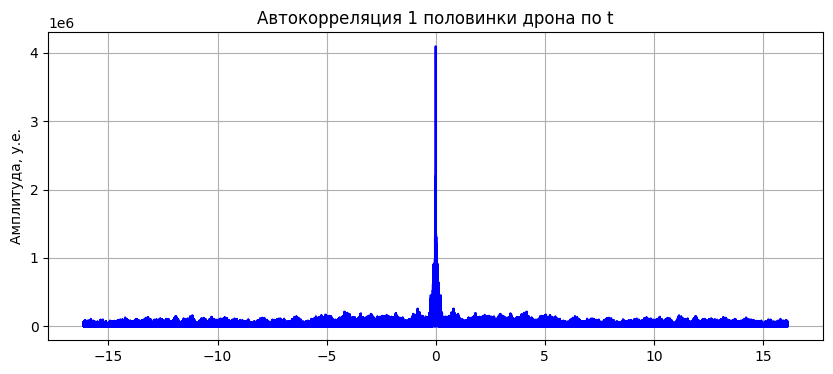

In [40]:
autocorr_first = corr_t(data_first, data_first)
plot1(t_central, np.abs(autocorr_first), 'Автокорреляция 1 половинки дрона по t')

/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_1575/476751496.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  s1[i] = data1_f[i]
/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_1575/476751496.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  s2[i] = data2_f[i]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


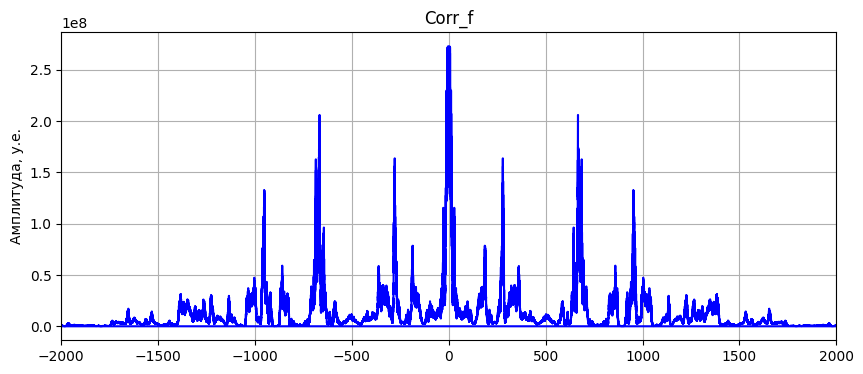

In [25]:
c_f2 = corr_f(data1_0db, data1_70db, 1000)
plot1_f(f1, c_f1, 'Corr_f', 2000)